# Abstract

-- insert here --

# Data and Feature Selection

We are using the `folkables` package to access data from the 2018 American Community Survey's Public Use Microdata Sample (PUMS) for the state of Georgia.

In [5]:
from folktables import ACSDataSource, ACSEmployment, BasicProblem, adult_filter
import numpy as np

STATE = "GA"

data_source = ACSDataSource(survey_year='2018', 
                            horizon='1-Year', 
                            survey='person')

acs_data = data_source.get_data(states=[STATE], download=True)

acs_data.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP71,PWGTP72,PWGTP73,PWGTP74,PWGTP75,PWGTP76,PWGTP77,PWGTP78,PWGTP79,PWGTP80
0,P,2018GQ0000025,5,1,3700,3,13,1013097,68,51,...,124,69,65,63,117,66,14,68,114,121
1,P,2018GQ0000035,5,1,1900,3,13,1013097,69,56,...,69,69,7,5,119,74,78,72,127,6
2,P,2018GQ0000043,5,1,4000,3,13,1013097,89,23,...,166,88,13,13,15,91,163,13,89,98
3,P,2018GQ0000061,5,1,500,3,13,1013097,10,43,...,19,20,3,9,20,3,3,10,10,10
4,P,2018GQ0000076,5,1,4300,3,13,1013097,11,20,...,13,2,14,2,1,2,2,13,14,12


This data set contains a large amount of features for each individual, so we are going to narrow it down to only those that we may use to train our model.

In [7]:
possible_features=['AGEP', 'SCHL', 'MAR', 'RELP', 'DIS', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'NATIVITY', 'DEAR', 'DEYE', 'DREM', 'SEX', 'RAC1P', 'ESR']
acs_data[possible_features].head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,RAC1P,ESR
0,51,13.0,5,16,2,NaN,1,3.0,4.0,1,1,2,2,2.0,1,2,6.0
1,56,16.0,3,16,1,NaN,1,1.0,4.0,4,1,2,1,2.0,2,1,6.0
2,23,20.0,5,17,1,NaN,1,1.0,4.0,4,1,2,2,1.0,2,2,1.0
3,43,17.0,1,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,1,2,6.0
4,20,19.0,5,16,2,NaN,1,1.0,4.0,1,1,2,2,2.0,2,1,6.0


A few key features to note are:

- `ESR` is employment status (`1` if employed, `0` if not)
- `RAC1P` is race (`1` for White Alone, `2` for Black/African American Alone, `3` and above for other self-identified racial groups)
- `SEX` is binary sex (`1` for male, `2` for female)

Now we select for the features we want to use and we will be able to constuct a `BasicProblem` that expresses our desire to use these features to predict employment status `ESR`, using `RAC1P` as the group label. 

In [8]:
features_to_use = [f for f in possible_features if f not in ["ESR", "RAC1P"]]

In [9]:
EmploymentProblem = BasicProblem(
    features=features_to_use,
    target='ESR',
    target_transform=lambda x: x == 1,
    group='RAC1P',
    preprocess=lambda x: x,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

features, label, group = EmploymentProblem.df_to_numpy(acs_data)

We now have a feature matrix `features`, a label vector `label`, and a group label vector `group`.

In [10]:
for obj in [features, label, group]:
  print(obj.shape)

(100855, 15)
(100855,)
(100855,)


We are now going to split our data into a training set and a testing set:

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
    features, label, group, test_size=0.2, random_state=0)

# Data Exploration

Before we dive straight into  model training, lets take a deeper look at our data.

In [17]:
import pandas as pd
df = pd.DataFrame(X_train, columns = features_to_use)
df["group"] = group_train
df["label"] = y_train

Here is a quick look at our data frame containing our training data:

In [18]:
df.head()

,AGEP,SCHL,MAR,RELP,DIS,ESP,CIT,MIG,MIL,ANC,NATIVITY,DEAR,DEYE,DREM,SEX,group,label
0,48.0,16.0,1.0,1.0,2.0,0.0,1.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2,True
1,52.0,24.0,2.0,0.0,2.0,0.0,1.0,3.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,1,True
2,55.0,18.0,5.0,0.0,2.0,0.0,1.0,1.0,4.0,3.0,1.0,2.0,2.0,2.0,1.0,2,True
3,15.0,12.0,5.0,3.0,2.0,1.0,4.0,3.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,6,False
4,26.0,22.0,1.0,0.0,2.0,0.0,5.0,1.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,2,False


In [24]:
len(df)

80684

This data set contains information from $80684$ individuals in the state of Georgia.

In [ ]:
df["label"].value_counts()

label
False    44664
True     36020
Name: count, dtype: int64

In [58]:
df['label'].mean()

np.float64(0.44643299786822666)

Of these individuals, 44.64% or $44664$ individuals are employed.

In [62]:
df['group'].value_counts()

group
1    53302
2    20239
6     3267
9     1996
8     1589
3      159
5       66
7       66
Name: count, dtype: int64

In [65]:
df['group'].value_counts(normalize=True)

group
1    0.660627
2    0.250843
6    0.040491
9    0.024738
8    0.019694
3    0.001971
5    0.000818
7    0.000818
Name: proportion, dtype: float64

The two largest racial groups are `1` White Alone with 53302 individuals making up 66% of the data, and `2` Black/African American Alone with 20239 individuals making up 25% of the data.

In [64]:
df.groupby('group')['label'].mean()

group
1    0.460771
2    0.416127
3    0.433962
5    0.348485
6    0.481175
7    0.484848
8    0.429830
9    0.330160
Name: label, dtype: float64

~46% of White Alone individuals are employed and ~42% of Black/African American Alone individuals are employed.

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

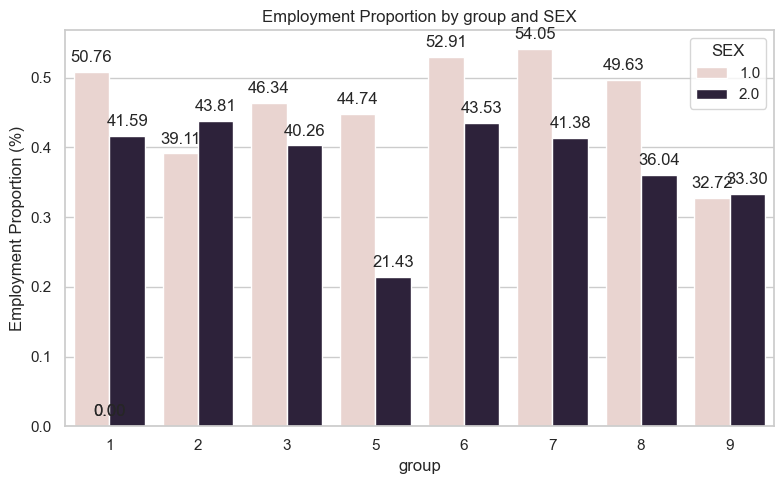

In [92]:
def plot_intersection(df, col1='group', col2='sex'):
    prop_df = df.groupby([col1, col2])['label'].mean().reset_index()
    plt.figure(figsize=(8, 5))

    ax = sns.barplot(x=col1, y='label', hue=col2, data=prop_df)
    
    plt.title(f'Employment Proportion by {col1} and {col2}')
    plt.xlabel(col1)
    plt.ylabel(f'Employment Proportion (%)')

    for p in ax.patches:
        ax.annotate(f'{p.get_height()*100:.2f}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'bottom',
                   xytext = (0, 5), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.show()

group_sex = plot_intersection(df, 'group', 'SEX')
    

For many groups, the percentage of men who are employed is higher than that of women. One notable group where this is not the case is `2` Black/African American where the percentage of employed women is ~44% against ~39% for men.

`NATIVITY` indicates a persons place of birth. `1` being Native born and `2` being Foreign born.

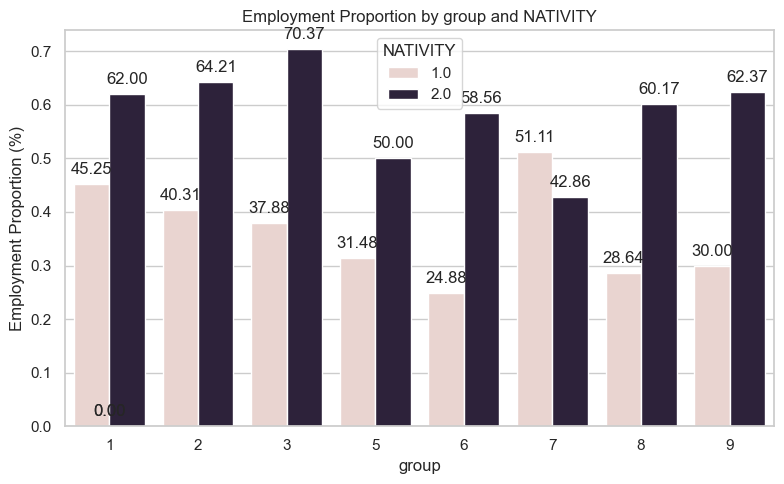

In [93]:
group_nativity = plot_intersection(df, 'group', 'NATIVITY')

Interestingly, across the board we see that the percentage of foreign born individuals who are employed is much higher than the proportion of native born individuals. However, as seen in the plot below, this may be attributed to the fact that few foreign born individuals on the extremities of the age, reducing the influence of youth and seniority as factors in employment proportion.

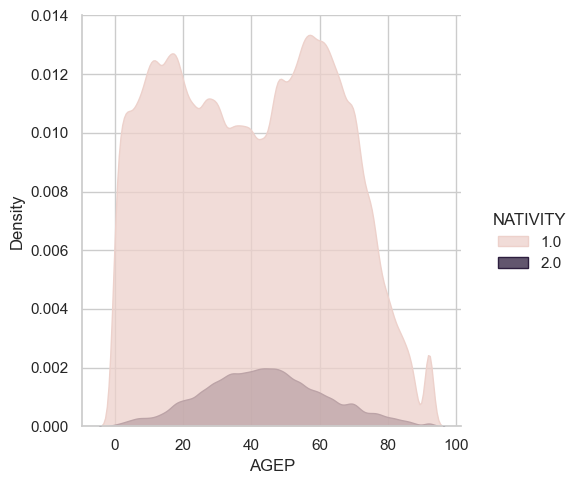

In [85]:
sns.displot(data=df, x="AGEP", hue="NATIVITY", kind="kde", bw_adjust=0.5, fill=True, alpha=0.75)

`DIS` represents an individuals disability status. `1` with disability, and `2` without a disability.

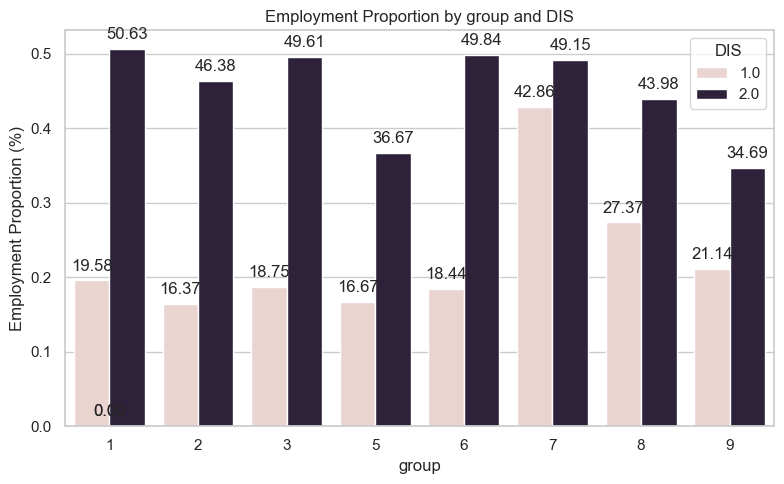

In [94]:
group_dis = plot_intersection(df, 'group', 'DIS')

Across the board we see that people without disability are employed at a much higher proportion than people with disabilities.

*Supplementary plots that I though were interesting.*

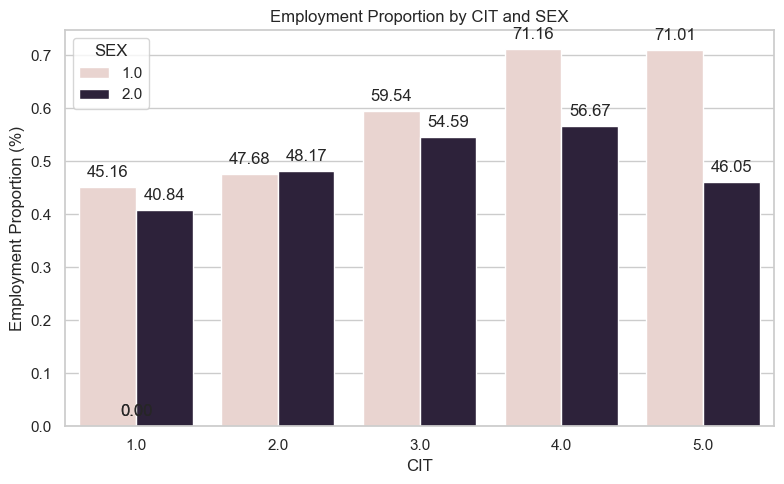

In [95]:
cit_sex = plot_intersection(df, 'CIT', 'SEX')

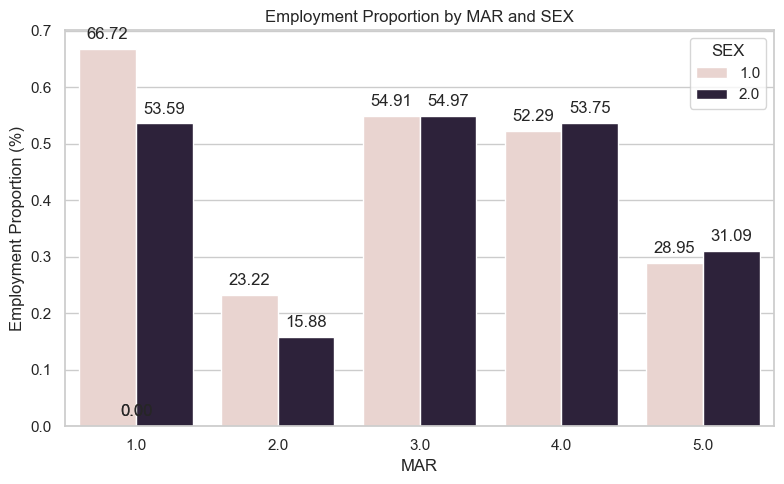

In [96]:
mar_sex = plot_intersection(df, 'MAR', 'SEX')

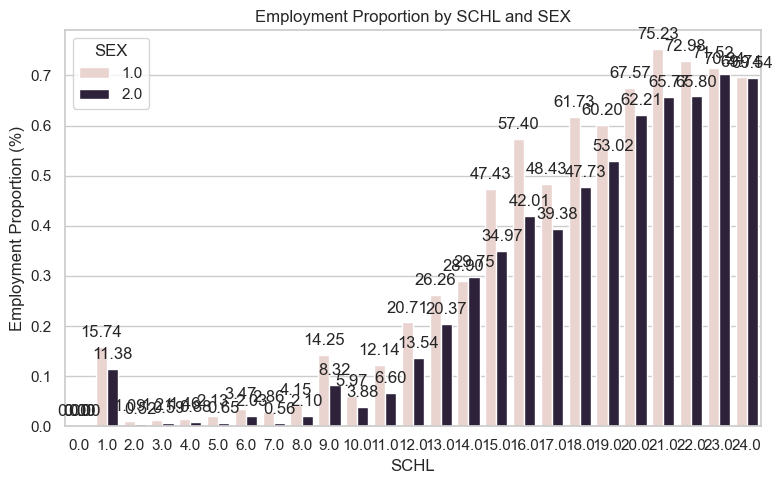

In [99]:
schl_sex = plot_intersection(df, 'SCHL', 'SEX')

# Model Training

We are now ready to create a model and train it on our training data. We will first scale our data, then we will employ a Random Forest Classifier. This approach uses an array of decision trees on various sub-samples of the data and aggregates their results. Learn more [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

model = make_pipeline(StandardScaler(), RandomForestClassifier())
model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier', RandomForestClassifier())])

In [13]:
y_hat = model.predict(X_test)